In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pretrained_model = "data/lenet_mnist_model.pth"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
model = Net().to(device)

In [5]:
model.load_state_dict(torch.load(pretrained_model))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [6]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [7]:
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred_label = output.max(1, keepdim=True)[1]
    print(pred_label)
    print(data.size())
    break

tensor([[7]], device='cuda:0')
torch.Size([1, 1, 28, 28])


In [8]:
picture = data.squeeze().detach().cpu().numpy()

Target Label:  7
Predicted Label:  7


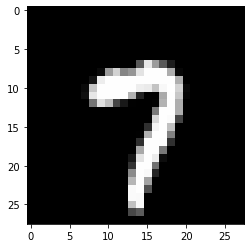

In [9]:
plt.imshow(picture, cmap='gray')
print("Target Label: ", target.item())
print("Predicted Label: ", pred_label.item())

In [26]:
test_count = np.zeros(10)
for data, target in test_loader:
    data = data.to(device)
    for i in range (10):
        if model(data).max(1, keepdim=True)[1].item() == i and target.item() == i:
            test_count[i] += 1

print(test_count)

[ 972. 1126. 1019.  988.  972.  877.  943.  979.  964.  970.]


In [21]:
def test(model, device, test_loader, epsilon, num):
    count = 0
    correct = 0
    num_identified = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        #If prediction is already wrong go to next item
        if init_pred.item() != target.item():
            continue
        
        #Creates Adversarial Image
        for i in range(40):
            if output.max(1, keepdim=True)[1].item() == num or epsilon == 0:
                break
            loss = F.cross_entropy(output, torch.tensor([num]).to(device))

            model.zero_grad()
            loss.backward()

            data_grad = data.grad.data.sign()

            perturbed_image = data - epsilon*data_grad

            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            data = perturbed_image.clone().detach()
            
            data.requires_grad_()
            
            output = model(data)

            count += 1

        final_pred = output.max(1, keepdim=True)[1]

        #Adds adversarial examples if wrong
        if final_pred.item() == target.item():
            correct += 1
            if target.item() == num:
                num_identified += 1

            if (epsilon == 0) and (len(adv_examples) < 10):
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
        else:
            if final_pred.item() == num:
                num_identified += 1
            if len(adv_examples) < 10:
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
    final_acc = correct/float(len(test_loader))
    num_acc = num_identified/float(len(test_loader))
    cycles_per = count/(len(test_loader)-190)
    print("Number Target: {}\tTest Accuracy = {} / {} = {}\tPercent Classified as Target = {} / {} = {}\t Cycles per image = {:.4f}".format(num, correct, len(test_loader), final_acc, num_identified, len(test_loader), num_acc, cycles_per))

    return final_acc, num_acc, adv_examples, cycles_per

In [22]:
%%time
target_acc = []
accuracies = []
examples = []
cycles = []
epsilon = .008
numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for num in numbers:
    acc, num_acc, ex, cyc = test(model, device, test_loader, epsilon, num)
    accuracies.append(acc)
    examples.append(ex)
    target_acc.append(num_acc)
    cycles.append(cyc)

Number Target: 0	Test Accuracy = 1402 / 10000 = 0.1402	Percent Classified as Target = 8560 / 10000 = 0.856	 Cycles per image = 28.2128
Number Target: 1	Test Accuracy = 1615 / 10000 = 0.1615	Percent Classified as Target = 8765 / 10000 = 0.8765	 Cycles per image = 25.8406
Number Target: 2	Test Accuracy = 1028 / 10000 = 0.1028	Percent Classified as Target = 9755 / 10000 = 0.9755	 Cycles per image = 20.8259
Number Target: 3	Test Accuracy = 1036 / 10000 = 0.1036	Percent Classified as Target = 9629 / 10000 = 0.9629	 Cycles per image = 22.2130
Number Target: 4	Test Accuracy = 1346 / 10000 = 0.1346	Percent Classified as Target = 9147 / 10000 = 0.9147	 Cycles per image = 25.1178
Number Target: 5	Test Accuracy = 878 / 10000 = 0.0878	Percent Classified as Target = 9702 / 10000 = 0.9702	 Cycles per image = 21.6088
Number Target: 6	Test Accuracy = 1051 / 10000 = 0.1051	Percent Classified as Target = 8538 / 10000 = 0.8538	 Cycles per image = 26.5414
Number Target: 7	Test Accuracy = 1655 / 10000 = 0.

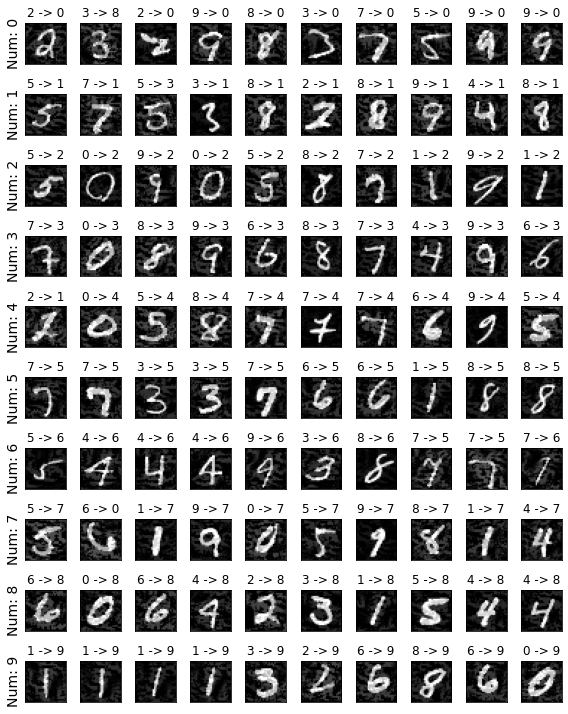

In [23]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(numbers)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(numbers),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Num: {}".format(numbers[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

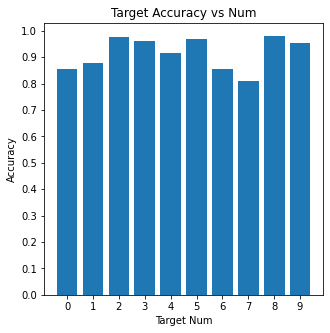

In [38]:
plt.figure(figsize=(5,5))
plt.bar(numbers, target_acc)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, numbers[-1] + 1, step=1))
plt.title("Target Accuracy vs Num")
plt.xlabel("Target Num")
plt.ylabel("Accuracy")
plt.show()

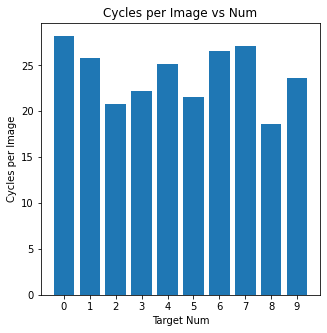

In [39]:
plt.figure(figsize=(5,5))
plt.bar(numbers, cycles)
#plt.yticks(np.arange(15, 30, step=1))
plt.xticks(np.arange(0, numbers[-1] + 1, step=1))
plt.title("Cycles per Image vs Num")
plt.xlabel("Target Num")
plt.ylabel("Cycles per Image")
plt.show()

In [50]:
import pandas as pd

nd = np.array([accuracies, target_acc, cycles])
nd = np.transpose(nd)
df = pd.DataFrame(nd, columns=["Accuracy", "Targeted Accuracy", "Cycles per Image"])
print(df)

   Accuracy  Targeted Accuracy  Cycles per Image
0    0.1402             0.8560         28.212844
1    0.1615             0.8765         25.840571
2    0.1028             0.9755         20.825892
3    0.1036             0.9629         22.213048
4    0.1346             0.9147         25.117839
5    0.0878             0.9702         21.608767
6    0.1051             0.8538         26.541386
7    0.1655             0.8107         27.106422
8    0.0969             0.9805         18.656983
9    0.1058             0.9550         23.670031


In [59]:
df.to_csv("Targeted_BIM_Data.csv")

In [60]:
df = pd.read_csv("Targeted_BIM_Data.csv", index_col=0)
print(df)

   Accuracy  Targeted Accuracy  Cycles per Image
0    0.1402             0.8560         28.212844
1    0.1615             0.8765         25.840571
2    0.1028             0.9755         20.825892
3    0.1036             0.9629         22.213048
4    0.1346             0.9147         25.117839
5    0.0878             0.9702         21.608767
6    0.1051             0.8538         26.541386
7    0.1655             0.8107         27.106422
8    0.0969             0.9805         18.656983
9    0.1058             0.9550         23.670031


Original:  9 
Adversarial: 3


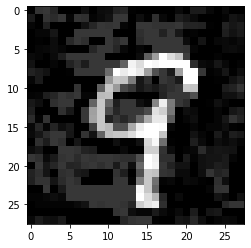

In [62]:
orig, adv, img = examples[3][3]
plt.imshow(img, cmap='gray')
print("Original: ", orig, "\nAdversarial:", adv)

In [139]:
images = []
for j in range(10):    
    data = torch.zeros((1,1,28,28)).to(device)
    data.requires_grad = True
    output = model(data)
    for i in range(10000):
        loss = F.cross_entropy(output, torch.tensor([j]).to(device))
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data.sign()
        perturbed_image = data - .001*data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        data = perturbed_image.clone().detach()
        data.requires_grad_()
        output = model(data)

    img = perturbed_image.squeeze().detach().cpu().numpy()
    images.append(img)

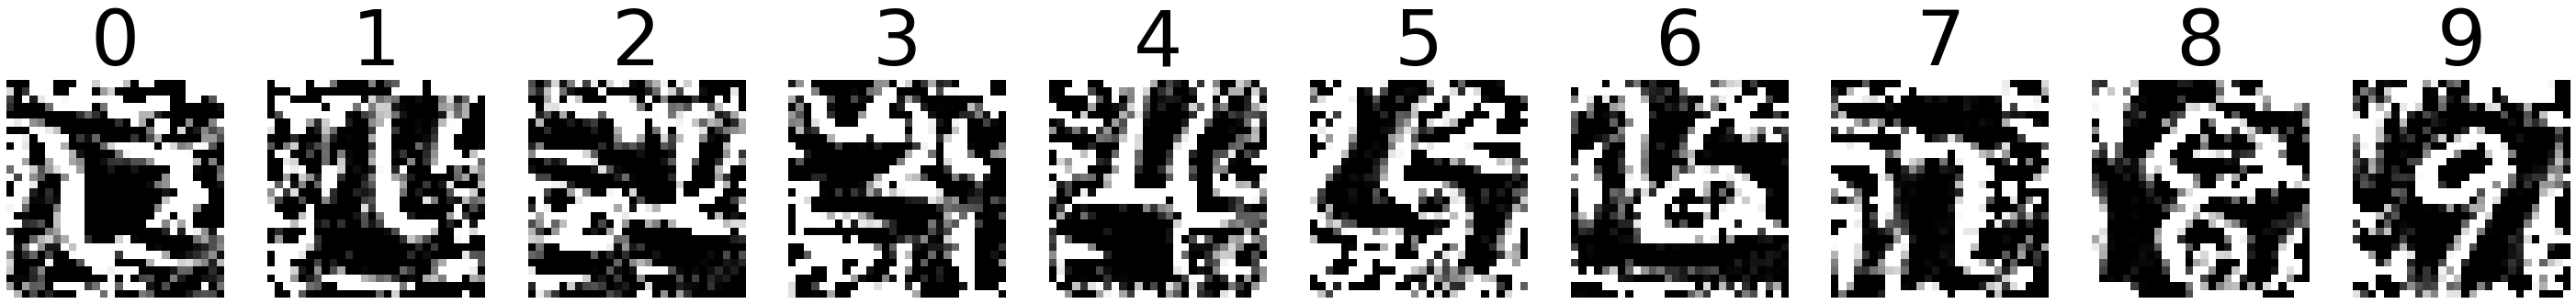

In [154]:
plt.figure(figsize=(50,50))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.title(i, fontsize = '84')
    plt.imshow(images[i], cmap='gray')
plt.savefig('perfect-numbers.jpg')

In [210]:
dl = torch.utils.data.DataLoader(torch.tensor(images), batch_size=1)
total = np.zeros(10)
for x, batch in enumerate(dl):
    batch = batch.unsqueeze(0)
    batch = batch.to(device)
    output = model(batch)
    s = nn.Softmax(dim=1)
    output = s(output)
    output = output.cpu().detach().numpy().squeeze(0)
    total = np.add(output, total)
    total[x] = total[x] - output[x]

print(total)

[6.74815533e-05 2.36971938e-04 2.99823884e-03 1.57925741e-03
 1.44184915e-03 7.52807357e-04 8.51656917e-04 9.90923407e-04
 1.37785629e-03 4.27575052e-04]
